In [1]:
from __future__ import unicode_literals, print_function, division
import random
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.nn.functional as F
import time
from utils import timeSince

from cn_cn_data import get_cn_en_dataloader, to_sentence, cn_vocab, en_vocab


In [2]:
seq_len = 15
max_length = seq_len + 2
batch_size = 1

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_dataloader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 2207


In [3]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)

    print([idx.item() for idx in item[0]])
    print(to_sentence(item[0], True))
    print([idx.item() for idx in item[1]])
    print(to_sentence(item[1], False))
    break

torch.Size([9, 1]) torch.Size([10, 1])
[2, 177, 24, 254, 50, 437, 1017, 5, 3]
['<sos>', '她', '会', '十', '门', '语', '言', ' 。', '<eos>']
[2, 131, 262, 1333, 516, 1565, 1058, 2986, 5, 3]
['<sos>', 'She', 'is', 'able', 'to', 'speak', 'ten', 'languages', '.', '<eos>']


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        batch_size = input.size(1)
        hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.gru(embedded, hidden)

        return outputs, hidden


In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)

        hidden = hidden.permute(1, 0, 2)
        # repeat decoder hidden state src_len times, hidden = [batch, seq_len, hidden size]
        hidden = hidden.repeat(1, seq_len, 1)

        # [batch, seq_len, hidden size * 2]
        outputs_cat_hidden = torch.cat((hidden, encoder_outputs), dim=2)

        # energy = [batch, seq_len, hidden size]
        energy = torch.tanh(self.attn(outputs_cat_hidden))

        # attention= [batch, seq_len]
        attention = self.v(energy).squeeze(2)

        return self.softmax(attention)


In [6]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.attention = Attention(hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size * 3, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch, 1]
        # hidden = [1, batch, hidden_size]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch, seq_len, hidden size]
        # embedded = [1, batch, hidden_size]
        embedded = self.dropout(self.embedding(input)).unsqueeze(0)

        # [batch, 1, seq_len]
        attention = self.attention(hidden, encoder_outputs).unsqueeze(1)

        # weighted = [batch, 1, hidden_size]
        weighted_encoder_outputs = torch.bmm(attention, encoder_outputs).permute(1, 0, 2) # (1, batch, hidden_size)

        # output = [seq_len, batch, hidden_size], hidden = [n_layers(1), batch, hidden_size]
        output, hidden = self.rnn(torch.cat((embedded, weighted_encoder_outputs), dim=2), hidden)

        embedded = embedded.squeeze(0) # [batch, hidden_size]
        output = output.squeeze(0) # [batch, hidden_size]
        weighted_encoder_outputs = weighted_encoder_outputs.squeeze(0) # [batch, hidden_size]

        prediction = F.log_softmax(self.out(torch.cat((output, weighted_encoder_outputs, embedded), dim=1)), dim=1) # [batch, output _ize]
        return prediction, hidden, attention


In [7]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)
    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_input = input_tensor[0]
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # detach from history as input

            target = target_tensor[di]
            loss += criterion(decoder_output, target)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [8]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.005):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss(ignore_index=cn_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input_tensor, target_tensor = data

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [9]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

train_losses = []
for i in range(15):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=500)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 37s (- 2m 9s) (500 22%) 4.3567
1m 15s (- 1m 31s) (1000 45%) 3.5051
1m 53s (- 0m 53s) (1500 67%) 3.3465
2m 31s (- 0m 15s) (2000 90%) 3.2210
--------------epoch 2--------------
0m 37s (- 2m 8s) (500 22%) 2.8039
1m 14s (- 1m 29s) (1000 45%) 2.8037
1m 52s (- 0m 53s) (1500 67%) 2.7448
2m 30s (- 0m 15s) (2000 90%) 2.7067
--------------epoch 3--------------
0m 37s (- 2m 7s) (500 22%) 2.4285
1m 14s (- 1m 30s) (1000 45%) 2.4641
1m 52s (- 0m 53s) (1500 67%) 2.4006
2m 29s (- 0m 15s) (2000 90%) 2.3327
--------------epoch 4--------------
0m 37s (- 2m 6s) (500 22%) 2.1035
1m 14s (- 1m 30s) (1000 45%) 2.1204
1m 52s (- 0m 52s) (1500 67%) 2.1281
2m 29s (- 0m 15s) (2000 90%) 2.1142
--------------epoch 5--------------
0m 36s (- 2m 5s) (500 22%) 1.8245
1m 14s (- 1m 29s) (1000 45%) 1.8533
1m 51s (- 0m 52s) (1500 67%) 1.9047
2m 28s (- 0m 15s) (2000 90%) 1.8957
--------------epoch 6--------------
0m 37s (- 2m 6s) (500 22%) 1.5599
1m 14s (- 1m 29s) (1000 45%) 1.6784
1m 5

<Figure size 640x480 with 0 Axes>

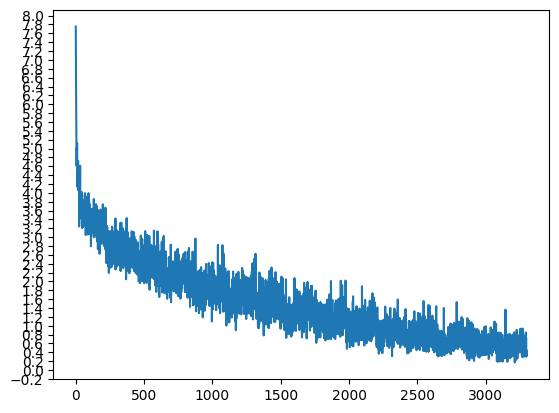

In [10]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [11]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [13]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [14]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        input_tensor = input_tensor.permute(1, 0)
        input_length = input_tensor.size(0)

        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words[1:], decoder_attentions[:di + 1]


In [15]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [16]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [17]:
evaluateRandomly(encoder2, decoder2)


> 他总是忘记事情。
= He is always forgetting things.
< He 's always forgetting things . <EOS>

> 我们是特别的。
= We're special.
< We 're special . <EOS>

> 我是个社会工作人员。
= I'm a social worker.
< I 'm a social worker . <EOS>

> 他有点像他的父亲。
= He's a little like his father.
< He 's a little like his father . <EOS>

> 他和所有同学的关系都不错。
= He is on goods terms with all of his classmates.
< He is on goods terms with all of his classmates . <EOS>

> 你总是批评我！
= You're always criticizing me.
< You are always criticizing me . <EOS>

> 你真是个努力的工人。
= You're really a hard worker.
< You 're such an excellent to . <EOS>

> 我愿意参加这场会议。
= I'm willing to attend the meeting.
< I 'm willing to attend the meeting . <EOS>

> 我很高兴没有买这样的东西。
= I'm glad that I didn't buy something like this.
< I 'm glad I did n't buy something like this . <EOS>

> 她是一个著名的歌手。
= She is a noted singer.
< She is a famous singer . <EOS>



<sos> I 'm not sure . <EOS>


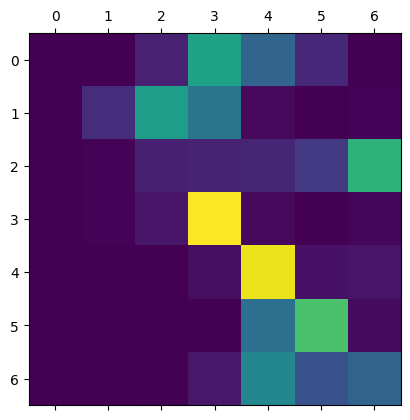

In [ ]:
output_words, attentions = evaluate(encoder2, decoder2, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.matshow(attentions.numpy())
